In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate
from scipy.integrate import odeint

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
                 
import seaborn as sns
import requests
from bs4 import BeautifulSoup

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
df_analyse=pd.read_csv('../data/processed/COVID_small_flat_table_confirmed.csv',sep=';')  
df_analyse.sort_values('date',ascending=True).head()

,date,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,...,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,West Bank and Gaza,Yemen,Zambia,Zimbabwe
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,3000010,...,0,0,0,0,0,2,0,0,0,0


In [3]:
df_population=pd.read_csv('../data/processed/pouplation_country.csv',sep=',')  
df_population.dropna(inplace=True)
df_population.set_index('country', inplace=True)

## Simulative approach to calculate SIR curves

### Programming the Exposed and Dead Component

In [4]:
def deriv(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [5]:
N = df_population.loc['Germany']['population']
D = 5.0 # infections lasts five days
gamma = 1.0 / D
delta = 1.0 / 5.0  # incubation period of five days
R_0 = 5.0
beta = R_0 * gamma  # R_0 = beta / gamma, so beta = R_0 * gamma
alpha = 0.2  # 20% death rate
rho = 1/14  # 14 days from infection until death
S0, E0, I0, R0, D0 = N-1, 1, 0, 0, 0  # initial conditions: one exposed

In [6]:
t_de = np.linspace(0, 230, 231) # Grid of time points (in days)
y0 = S0, E0, I0, R0, D0 # Initial conditions vector

# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t_de, args=(N, beta, gamma, delta, alpha, rho))
S, E, I, R, D = ret.T

In [7]:
seird_dataframe = pd.DataFrame({'susceptible':S,
                                        'exposed' : E,
                                        'infected': I,
                                        'recovered': R,
                                         'dead': D
                                         })

seird_dataframe.head()

,susceptible,exposed,infected,recovered,dead
0,8.383608e+07,1.000000,0.000000,0.000000,0.000000
1,8.383608e+07,0.902698,0.171454,0.014369,0.001283
2,8.383608e+07,0.961846,0.313322,0.053320,0.004761
3,8.383608e+07,1.136859,0.454655,0.114618,0.010234
4,8.383608e+07,1.416002,0.615357,0.199848,0.017844


In [8]:
seird_dataframe["total"] = seird_dataframe.sum(axis=1)

## Vary R0 as a function of time t

In [9]:
def deriv1(y, t, N, beta, gamma, delta, alpha, rho):
    S, E, I, R, D = y
    dSdt = -beta(t) * S * I / N
    dEdt = beta(t) * S * I / N - delta * E
    dIdt = delta * E - (1 - alpha) * gamma * I - alpha * rho * I
    dRdt = (1 - alpha) * gamma * I
    dDdt = alpha * rho * I
    return dSdt, dEdt, dIdt, dRdt, dDdt

In [10]:
def plotR0ForDifferentLockdowndays(lockdown):
    N1 = df_population.loc['Germany']['population']
#     N1 = 1000000
    D1 = 5.0 # infections lasts five days
    gamma1 = 1.0 / D1
    delta1 = 1.0 / 5.0  # incubation period of five days
    def R_0(t):
        return 5.0 if t < lockdown else 0.9
    def beta(t):
        return R_0(t) * gamma1

    alpha1 = 0.2  # 20% death rate
    rho1 = 1/9  # 9 days from infection until death
    S01, E01, I01, R01, D01 = N1-1, 1, 0, 0, 0  # initial conditions: one exposed
    
    t1 = np.linspace(0, 230, 231)

    # Initial conditions vector
    y01 = S01, E01, I01, R01, D01 

    # Integrate the SIR equations over the time grid, t.
    ret1 = odeint(deriv1, y01, t1, args=(N1, beta, gamma1, delta1, alpha1, rho1))
    S1, E1, I1, R1, D1 = ret1.T
    
    df_r0 = pd.DataFrame({'susceptible':S1,
                                        'exposed' : E1,
                                        'infected': I1,
                                        'recovered': R1,
                                         'dead': D1
                                         })
    return df_r0

In [11]:
# Determine how a lockdown after 50 days effects the future spread of the disease
seird_dataframe_r0 = plotR0ForDifferentLockdowndays(50)
seird_dataframe_r0_40 = plotR0ForDifferentLockdowndays(40)

In [12]:
seird_dataframe_r0_40.head()

,susceptible,exposed,infected,recovered,dead
0,8.383608e+07,1.000000,0.000000,0.000000,0.000000
1,8.383608e+07,0.902475,0.170773,0.014331,0.001990
2,8.383608e+07,0.960277,0.310828,0.053042,0.007367
3,8.383608e+07,1.132030,0.449222,0.113723,0.015795
4,8.383608e+07,1.405203,0.605550,0.197756,0.027466


In [13]:
seird_dataframe_r0.head()

,susceptible,exposed,infected,recovered,dead
0,8.383608e+07,1.000000,0.000000,0.000000,0.000000
1,8.383608e+07,0.902475,0.170773,0.014331,0.001990
2,8.383608e+07,0.960277,0.310828,0.053042,0.007367
3,8.383608e+07,1.132030,0.449222,0.113723,0.015795
4,8.383608e+07,1.405203,0.605550,0.197756,0.027466


In [14]:
graph_types_1=['infected',
              'susceptible',
              'recovered',
             'exposed',
            'dead'
             ] 

## Dynamic parameters in SIR (infection rate)

In [15]:
t = np.arange(len(df_analyse['Germany'][35:]))
ydata=np.array(df_analyse['Germany'][35:])
N0=1000000
# ensure re-initialization 
I0=ydata[0]
S0=N0-I0
R0=0

In [16]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          #S*I is the 
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [17]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
   
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] # we only would like to get dI

In [18]:
def getOptimalBetaAndGamma(beta,gamma,timesteps,ydata,country):    
    
    global N0
    if country in df_population.index:
        N0=df_population.loc[country]['population']
    else:
        N0 = 1000000
    global I0
    I0 = ydata[0]
    global S0
    S0 = N0-I0
    global R0
    R0 = 0
    global t
    t = timesteps
    
    popt=[beta,gamma]
    fit_odeint(t, *popt)
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))     

    # get the final fitted curve
    fitted=fit_odeint(t, *popt) 
    return fitted,popt

In [19]:
ydata = np.array(df_analyse['Germany'][35:])
t=np.arange(len(ydata))
print(len(ydata),len(t))
fitted,popt = getOptimalBetaAndGamma(0.4,0.1,t,ydata,'Germany')


287 287


c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()
c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in double_scalars
c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars


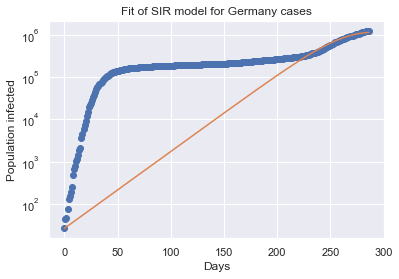

Optimal parameters: beta = 0.26175091551480517  and gamma =  0.21997930528618198
Basic Reproduction Number R0  1.1898888178334794
This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki


In [20]:
plt.semilogy(t, ydata, 'o')
plt.semilogy(t, fitted)
plt.title("Fit of SIR model for Germany cases")
plt.ylabel("Population infected")
plt.xlabel("Days")
plt.show()
print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
print("Basic Reproduction Number R0 " , popt[0]/ popt[1])
print("This ratio is derived as the expected number of new infections (these new infections are sometimes called secondary infections from a single infection in a population where all subjects are susceptible. @wiki")

In [21]:
def SIR_model(SIR,beta,gamma,N):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''

    
    S,I,R=SIR
    dS_dt=-beta*S*I/N       #S*I is the 
    dI_dt=beta*S*I/N-gamma*I
    dR_dt=gamma*I
    
    return([dS_dt,dI_dt,dR_dt])


In [22]:
def fitCountryCurve(beta,gamma,country,infection_days,measures_days,hold,relax):

    t_initial=infection_days
    t_intro_measures=measures_days
    t_hold=hold
    t_relax=relax
    N0=1000000
    
    beta_max=beta
    beta_min=0.11
    gamma=gamma
    pd_dynamic=np.concatenate((np.array(t_initial*[beta_max]),
                       np.linspace(beta_max,beta_min,t_intro_measures),
                       np.array(t_hold*[beta_min]),
                        np.linspace(beta_min,beta_max,t_relax),
                       ))

    # condition I0+S0+R0=N0   

    if country in df_population.index:
        N0=df_population.loc[country]['population']

    I0=df_analyse[country][infection_days]
    S0=N0-I0
    R0=0
    

    SIR=np.array([S0,I0,R0])   

    propagation_rates=pd.DataFrame(columns={'susceptible':S0,
                                        'infected':I0,
                                        'recovered':R0})



    for each_beta in pd_dynamic:
   
        new_delta_vec=SIR_model(SIR,each_beta,gamma,N0)

        SIR=SIR+new_delta_vec

        propagation_rates=propagation_rates.append({'susceptible':SIR[0],
                                                    'infected':SIR[1],
                                                    'recovered':SIR[2]}, ignore_index=True)
    
    return propagation_rates

In [23]:
propagation_rates=fitCountryCurve(0.2,0.1,'India',60,70,80,80)
propagation_rates.infected

0      4.356000e+02
1      4.791599e+02
2      5.270759e+02
3      5.797834e+02
4      6.377617e+02
5      7.015378e+02
6      7.716915e+02
7      8.488605e+02
8      9.337464e+02
9      1.027121e+03
10     1.129833e+03
11     1.242816e+03
12     1.367097e+03
13     1.503806e+03
14     1.654186e+03
15     1.819604e+03
16     2.001564e+03
17     2.201719e+03
18     2.421889e+03
19     2.664077e+03
20     2.930483e+03
21     3.223529e+03
22     3.545879e+03
23     3.900463e+03
24     4.290505e+03
25     4.719551e+03
26     5.191500e+03
27     5.710642e+03
28     6.281697e+03
29     6.909856e+03
30     7.600828e+03
31     8.360894e+03
32     9.196964e+03
33     1.011664e+04
34     1.112827e+04
35     1.224106e+04
36     1.346513e+04
37     1.481159e+04
38     1.629268e+04
39     1.792188e+04
40     1.971397e+04
41     2.168526e+04
42     2.385365e+04
43     2.623885e+04
44     2.886254e+04
45     3.174855e+04
46     3.492312e+04
47     3.841508e+04
48     4.225616e+04
49     4.648126e+04


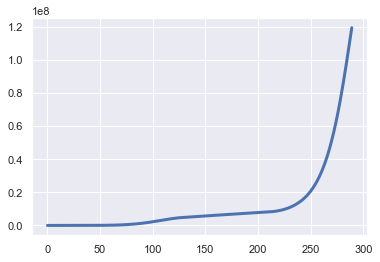

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.plot(propagation_rates.index,propagation_rates.infected,label='infected',linewidth=3)

## Dashboard

In [ ]:
import plotly.graph_objects as go
import requests
import json
import plotly

In [ ]:
graph_types_dead=['infected',
              'susceptible',
              'recovered',
             'exposed',
            'dead',
            'total'
             ] 

In [ ]:
colors = {
    'background': '#111111',
    'text': '#111111'
}

In [ ]:
country_list=df_analyse.columns[1:]
country_dropdown=[]
for country in country_list:
    country_dropdown.append({'label':country,'value':country})

In [ ]:
import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html


fig=go.Figure()
fig_1=go.Figure()

app = dash.Dash(external_stylesheets=['https://codepen.io/chriddyp/pen/bWLwgP.css'])

app.layout = html.Div([
    
       
                        html.H1(
                            children='SIR Modelling Dashboard',
                            style={
                                'textAlign': 'center',
                                'color': 'white',
                                'fontSize': 36,
                                "border":"2px black solid",
                                'margin-bottom': '30px',
                                'background': '#fb6107'
                            }
                        ),

                  
    
                        html.Div([                             
                                html.H2('SEIRD Modelling for Covid-19 - GERMANY',
                                        style={
                                                'textAlign': 'center',
                                                'color': colors['text'],
                                            'text-decoration': 'underline',
                                            'margin-bottom': '30px'
                                }),  
                               
                            html.Div(
                                html.Label('Category:', style={'fontSize':18}), style={'margin-bottom': '10px'}),
                                dcc.Dropdown(
                                    id='sir model',
                                    options=[
                                        {'label': 'infected', 'value': 'infected'},
                                        {'label': 'susceptible', 'value': 'susceptible'},
                                        {'label': 'recovered', 'value': 'recovered'},
                                        {'label': 'exposed', 'value': 'exposed'},
                                        {'label': 'dead', 'value': 'dead'},
                                        {'label': 'total', 'value': 'total'}
                                    ],
                                    value=['infected', 'recovered'], # which are pre-selected        
                                    multi = True
                                ),

                                dcc.Graph(figure=fig, id='main_window_slope')

                                ], style={'margin-bottom': '60px'}), 
    
    
    
                           html.Div([                             
                                html.H2('SEIRD Modelling for Covid-19 with varying R0(t) - GERMANY',
                                        style={
                                                'textAlign': 'center',
                                                'color': colors['text'],
                                            'text-decoration': 'underline',
                                            'margin-bottom': '30px'
                                })
                           ]),
                        
                    html.Div(
                        dcc.Dropdown(
                                    id='sir model_1',
                                    options=[
                                        {'label': 'infected', 'value': 'infected'},
                                        {'label': 'susceptible', 'value': 'susceptible'},
                                        {'label': 'recovered', 'value': 'recovered'},
                                        {'label': 'exposed', 'value': 'exposed'},
                                        {'label': 'dead', 'value': 'dead'}                                        
                                    ],
                                    value=['infected', 'exposed'], # which are pre-selected        
                                    multi = True
                                ),
                        
                    ),
            html.Br(),
                               
           html.Div([   
            html.Div([
                 html.Div(
                        html.Label('Lockdown after 40 days:', style={'fontSize':18}), style={'margin-bottom': '10px'}),
                                

                                dcc.Graph(figure=fig_1, id='main_window_slope_2')

                                ], className = "six columns", style={'margin-bottom': '60px'}),
            
            html.Div([
                 html.Div(
                        html.Label('Lockdown after 50 days:', style={'fontSize':18}), style={'margin-left' : '30px','margin-bottom': '10px'}),
                                

                                dcc.Graph(figure=fig_1, id='main_window_slope_1')

                                ],className = "six columns", style={'margin-bottom': '60px'}),
                        
               
                ], className = "row" ),
                               
                html.H2(children = 'Dynamic parameters in SIR (infection rate)', style={
                            'textAlign': 'center',
                            'color': colors['text'],
                            'text-decoration': 'underline',
                            'margin-bottom': '30px'
                        }),
    
                   html.Div([ 
                        html.Div(
                            html.Label('Select a Country:', style={'fontSize':28}), style={'margin-bottom': '10px'}),
                        dcc.Dropdown(
                                        id='country_drop_down',                                      
                                        options=country_dropdown,
                                        value='Germany', # which are pre-selected
                                        multi=False
                                    ),          
                        
                            ]),
                    
                   html.Br(),
                   html.Div([
                            html.Div([
                                html.Div([
                                        html.Label('Select value for beta',  style={
                                            'textAlign': 'left',
                                            'color': colors['text'], 'fontSize': 18
                                        })]), 

                                   html.Div(
                                   dcc.Slider(
                                        id='slider1',  
                                        max=2,
                                        min=0.2,
                                        value=0.3,
                                        step=0.01,
                                        updatemode='drag',

                                    ),style={"width": "30%", 'margin-top': '10px'} ),
                            ], className="six columns"),

                            html.Div([

                                    html.Div([ html.Label('Select value for gamma' ,  style={
                                            'textAlign': 'left',
                                            'color': colors['text'], 'fontSize': 18
                                        })]),

                                    html.Div(
                                    dcc.Slider(
                                        id='slider2',
                                        max=1,
                                        value=0.2,
                                        step=0.01,
                                        updatemode='drag'       
                                    ),   
                                    style={"width": "30%", 'margin-top': '10px'}),
                            ], className="six columns")
                   
                ],className="row"),
                
    
                html.Div(id='updatemode-output-container'), 
                
                html.Br(),
    
                html.Div([
                    html.Div([
                           html.Label('Infection started after (in days)',  style={
                                            'color': colors['text'], 'fontSize': 18
                                        }),                        
                        dcc.Input(id="infection_start", type="number", value=28)
                    ],className="six columns"),
                    
                    html.Div([
                        html.Label("Measures taken after (in days)",  style={
                                            'color': colors['text'], 'fontSize': 18
                                        }),                           
                        dcc.Input(id="measures_start", type="number", value=14), 
                    ],className="six columns"),
                    
                ], className="row"),
              html.Br(),
    
              html.Div([
                    
                html.Div([
                    html.Label('Hold (in days)',  style={
                                            'color': colors['text'], 'fontSize': 18
                                        }),                      
                    dcc.Input(id="hold_start", type="number", value=60)
                ],className="six columns"),
                                     
                html.Div([
                    html.Label('Relax (in days)',  style={
                                            'color': colors['text'], 'fontSize': 18
                                        }),                     
                    dcc.Input(id="relax_start", type="number", value=60),
                    
                ],className="six columns"),
                
            ],className="row"),
          
           html.Br(),
           html.Div([
               html.Label("Click to simulate SIR curve",style={
                                            'color': colors['text'], 'fontSize': 18
                                        }),
               html.Br(),
               html.Button('Submit', id='submit_btn', n_clicks=0)
           ]), 
           
    html.Div([dcc.Graph(id='my-output')]),


            ],style = {'margin':'auto','width': "50%"})  



In [ ]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope', 'figure'),
    [Input('sir model', 'value')])
def update_figure(graph_types):
    
    traces = [] 
    for each in graph_types:
        traces.append(dict(x=seird_dataframe.index,
                                y=seird_dataframe[each],
                                mode='lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each
                        )
                )
        
    return {
            'data': traces,
            'layout': dict (
                width=900,
                height=700,
                align= "center",
                title = "SIR Modelling with Exposed and Dead Components",
                #                 xaxis_title="Time",
#                 yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="black"),
                       "title": "Time in days" ,
                        'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      },
                
                yaxis={
                    "type": "log",
                    "title": "Number of people",
                    'tickfont':dict(size=14,color="black"),
                     'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      }
        )
    }

In [ ]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope_1', 'figure'),
    [Input('sir model_1', 'value')])
def update_figure(graph_types):
    
    traces = [] 
    for each in graph_types:
        traces.append(dict(x=seird_dataframe_r0.index,
                                y=seird_dataframe_r0[each],
                                mode='lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each
                        )
                )
        
    return {
            'data': traces,
            'layout': dict (
#                 width=600,
#                 height=600,
                align= "center",
                title = "SIR Modelling with time dependent R0",
                #                 xaxis_title="Time",
#                 yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="black"),
                       "title": "Time in days" ,
                        'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      },
                
                yaxis={
                    "title": "Number of people",
                    'tickfont':dict(size=14,color="black"),
                     'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      }
        )
    }

In [ ]:
from dash.dependencies import Input, Output

@app.callback(
    Output('main_window_slope_2', 'figure'),
    [Input('sir model_1', 'value')])
def update_figure(graph_types):
    
    traces = [] 
    for each in graph_types:
        traces.append(dict(x=seird_dataframe_r0_40.index,
                                y=seird_dataframe_r0_40[each],
                                mode='lines',
                                opacity=0.9,
                                line_width=2,
                                marker_size=4, 
                                name=each
                        )
                )
        
    return {
            'data': traces,
            'layout': dict (
#                 width=600,
#                 height=600,
                align= "center",
                title = "SIR Modelling with time dependent R0",
                #                 xaxis_title="Time",
#                 yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="black"),
                       "title": "Time in days" ,
                        'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      },
                
                yaxis={
                    "title": "Number of people",
                    'tickfont':dict(size=14,color="black"),
                     'titlefont': dict(
                        family = 'Comic Sans MS',
                        size = 18, 
                        color = '#e36414')
                      }
        )
    }

In [ ]:
@app.callback(
    Output('updatemode-output-container', 'children'),
    [Input('slider1', 'value'),
    Input('slider2', 'value')]
)
def update_slider(value1, value2):
    return 'Beta Value: {} | \
            Gamma Value: {}'.format(value1, value2)


In [ ]:
@app.callback(
    dash.dependencies.Output('my-output', 'figure'),
    [
        dash.dependencies.Input('country_drop_down', 'value'),
        dash.dependencies.Input('submit_btn','n_clicks')],
    [        
        dash.dependencies.State('infection_start', 'value'),
        dash.dependencies.State('measures_start', 'value'),
        dash.dependencies.State('hold_start', 'value'),
        dash.dependencies.State('relax_start', 'value'),
        dash.dependencies.State('slider1', 'value'),
        dash.dependencies.State('slider2', 'value')
    ])

def update_output(country_name,n_clicks,infection_days,measures_days,hold,relax,beta,gamma):
    traces=[]
    t=np.arange(len(df_analyse[country_name][infection_days:]))
    country_infected= np.array(df_analyse[country_name][infection_days:])
    df_test = pd.DataFrame({'t' : t, 'ydata' : df_analyse[country_name][infection_days:]})
    fitted,popt = getOptimalBetaAndGamma(beta,gamma,t,country_infected,country_name)
    df_dynamic = fitCountryCurve(beta,gamma,country_name,infection_days,measures_days,hold,relax)
    
    traces.append(dict(x=df_test.t,
                                y=df_test.ydata,
                                marker = {
                                    "color": "rgb(255, 51, 0)"},
                                type='bar',
                                name='Confirmed Infected cases')),
    
    traces.append(dict(x=df_dynamic.index,
                                y=df_dynamic.infected,
                                mode='lines',
                                marker = {
                                    "color": "rgb(0, 0, 255)"},
                                opacity=0.9,
                                line_width=4,
                                marker_size=4, 
                                name='Modelled Infected cases'
                        )),
    
    traces.append(dict(x=t,
                                y=fitted,
                                mode='markers+lines',
                                opacity=0.9,
                                line_width=4,
                                marker_size=4, 
                                name='Curve fit for optimal beta & gamma',marker_color = 'green'))

    return {
            'data': traces,
            'layout': dict (
                width=900,
                height=700,     
                title = "Fit of SIR model for " + country_name + " cases with given parameters.",
                #                 xaxis_title="Time",
            #                 yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
                xaxis={'tickangle':-45,
                        'nticks':20,
                        'tickfont':dict(size=14,color="black"),
                       "title": "Days" ,
                         'titlefont': dict(
                            family = 'Comic Sans MS',
                            size = 18, 
                            color = '#e36414')

                      },
                yaxis={
                    'range':'[1.1,5.5]',
                    'title':"No. of cases",
                    'type':'log',
                    "title": "Population infected",
                       'tickfont':dict(size=14,color="black"),
                       'titlefont': dict(
                            family = 'Comic Sans MS',
                            size = 18, 
                            color = '#e36414')
                      }
            )
         }   

In [ ]:
app.run_server(debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:8050/

 in production, use a production WSGI server like gunicorn instead.

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\scipy\integrate\odepack.py:248: ODEintWarning:

Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.

c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning:

overflow encountered in double_scalars

c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning:

overflow encountered in double_scalars

c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning:

overflow encountered in double_scalars

c:\users\akshatha\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning:

invalid value encountered in double_scalars

